###  <center>**WP-SN-2: Photometry of SN candidates** </center>

<center> 
Beatriz Antunes Langone, Catharina Arossi Patussi, Elisa Razzera Gajardo, William Simon Horn 
</center>

_________________


Briefly, the goal of our work is to perform the photometry of the images available in the database. For that, we have access,to the images for each field (five, in the total) and each epoch (20). Besides that, we have the csv file with the list of SN candidates and its positions in the images.

From the working group SN-1 we received the method to perform the difference of two images accounting for different seeing and the intercalibration values, in order to ensure that the flux in each pixel have the same meaning.

As a result, the code below perform the photrometry of the point-source in the images, giving its absolute magnitude.(This method was also passed to WP-SN-1)
With the magnitude, one can plot the lightcurve of each SN candidates, taking in consideration the error, as a function of epoch.



## Preparing the Data
First of all, let's install and import the tools that will be used in the program, as well as the database.
The Data-Photometry database contains data at different epochs for 5 different fields. It includes FITS files, the PSF data and CSV files with stars, galaxies and supernovae information.

In [0]:
!pip install photutils

#### Some usual imports
from pylab import *
from matplotlib import rc
%matplotlib inline
rc('figure',figsize=(17,10))
rc('font',size=12)
rc('text',usetex=False)
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import logging
import cmath as cm
import math
import random
import scipy
import photutils
from scipy.stats import norm
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.stats import gaussian_sigma_to_fwhm
import pandas
pandas.options.display.float_format = '{:,.2f}'.format
import glob


#### Reading file from Google Drive
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
##### Downloading Data-Photometry (WP-SN-2):
download = drive.CreateFile({'id': '1hCuUymLv2o17R9noyAV0Hrxp9CV8rv3k'})
download.GetContentFile('Data-Photometry.tgz')
!tar zxvf Data-Photometry.tgz


!ls -lrt

## Reading the DataBase
We'll read the Data-Photometry databases, separating the images of each field and putting them in order. 

In [0]:
##Defining some constants
#fields = 0,1,2,3,4
nb_fields=5

directory = 'Data-Photometry/'
globalname = 'EI2019-Data-Photometry-Field-'
files = glob.glob(directory+globalname+'*_images_epoch_*.fits') #Return a possibly-empty list of path names that match pathname

In [0]:
'''
  Basically, we use dictionaires for each data. The key is the field number (0,1,2,3,4) and the value is a list with the informations, one epoch per position
  sorted_field_dict == keeps all the images names of each field, already in chronological order
  epoch_dict == value is a list with all the epochs in the respective field
  sns_perField == value is a list with all the supernovas data in each epoch of the respective field
  psf_perField == value is a list of the psf in each epoch/field
  radius == the radius that will be used in order to calculate the magnitude (2* psf)
'''

#Dictionary where the key is the field number and the value is a list of the names of the images for each field
field_dict= {}

#This dictionary will receive the list of images chronologically ordered, with the field number as a key
sorted_field_dict ={}

#Epochs dictionaires
epoch_dict = {}
epochs_img_dict = {}

#Initialization of the dictionaires
for i in range(nb_fields):
  field_dict[str(i)] = []
  sorted_field_dict[str(i)] = []

for i in range(len(files)):
    name = files[i]
    bla = str.split(name,'_')
    field = int(bla[0][-1])
    field_dict[str(field)].append(name)

for i in range(nb_fields):
  epoch_dict[str(i)] = np.zeros(len(field_dict[str(i)]))
  epochs_img_dict[str(i)] = np.zeros(len(field_dict[str(i)]))

#Loop to order the list of images in field. At the end, sorted_field_dict have the ordered images name to each field
for index_field in range(nb_fields):
  list_field = field_dict[str(index_field)]
  for i in range(len(list_field)):
      name = list_field[i]
      bla = str.split(name,'_')
      epochs_img_dict[str(index_field)][i]= bla[-2]
  
  # Sort according to epoch
  s = np.argsort(epochs_img_dict[str(index_field)])
  
  files_sorted = np.zeros_like(list_field)
  for i in range(len(list_field)):
    epoch_dict[str(index_field)][i] = epochs_img_dict[str(index_field)][s[i]]
    files_sorted[i] = list_field[s[i]]
  
  sorted_field_dict[str(index_field)] = files_sorted

#We create also a dictionary with the SNIa in each field. Again, the key is the number of the field
sns_perField = {}

for i in range(nb_fields):
  sns_perField[str(i)] = []
  sns_perField[str(i)].append(pandas.read_csv(directory+globalname+str(i)+'_sns.csv'))
  
#To visualize, we use pandas. Example sns_perField['0'][0]


psf_perField = {}
for i in range(nb_fields):
  #We fill the psf dictionary, converting it to pixel
  psf_perField[str(i)] = np.loadtxt(directory+globalname+str(i)+'_PSF.txt') * 10

radius = {}
for key in psf_perField:
  radius[key] = (2*psf_perField[key])


With the results of the WP-SN-1, we create dictionaires for the intercalibration, the absolute calibration and the errors.

In [0]:
intercalibration = {'0': [1.1900027181005217, 0.6998012590439355, 1.0, 1.2039725995229904, 1.4069308911389085, 
                          0.6519866502321118, 0.7195667655630119, 0.962105276151982, 0.7532600245463134, 1.3736390132031495, 
                          0.7908598943906906, 1.064743539005377, 0.7785788238062338, 0.8585583094844407, 1.0167084425328707, 
                          1.4530569548638244, 1.1252925164583871, 0.6841042992666395, 0.7062303239396867, 1.149260099383334], 
                    '1':[0.8013245553623056, 1.1812711004379297, 1.0, 0.5491463928030703, 0.8362164049840469, 0.5950895968965235, 
                         0.38393374607451064, 1.0424492733601844, 0.8513314846854639, 0.5328027996505728, 0.85190537704388, 1.1401186606283888, 
                         0.7437780462256748, 0.6108795112979578, 0.7544291847333696, 1.1964660915303549, 0.7829439890797305, 1.1255223104839727, 
                         0.6195428582494166, 0.41114194735697573], 
                    '2': [2.4587741288229714, 1.568242571502225, 1.0, 1.5573769841500678, 2.8309203422904967, 1.3950165441349958, 
                          1.479600556599679, 2.214503172676245, 2.246952393102571, 2.21383459617932, 1.3648467115995835, 2.6102991328323664, 
                          1.2091090406413179, 2.352090536813476, 2.907535299743118, 1.1733912302848857, 2.740718686651379, 2.825027633479909, 
                          2.7091775008066166, 2.4880161897765016],
                    '3': [1.0743803071321034, 0.5553779725607293, 1.0, 0.5330357324004034, 0.9345238926821615, 1.0621575802256944,
                          0.6374666195540347, 0.9961961681196437, 0.4721056926300508, 0.6859159869567476, 0.9038824532280106, 1.089367832212073, 
                          0.9934353585165342, 0.7140411097509723, 0.533039646051147, 0.65113844114182, 0.4744729057422618, 1.129883386266313, 
                          0.42840375802296254, 0.6282696799134135],
                    '4': [1.5400982606336224, 1.5610834002218972, 1.0, 1.2823461665308538, 1.5943245963835757, 0.9597474171223146, 1.2227989729359674, 
                          1.3061842726845354, 1.0420158392591528, 0.9859435897669115, 1.33761676660217, 1.2399479832938993, 1.3905863238848173,
                          0.9321815754645112, 0.7347515053464564, 0.5984945251415322, 1.0164706004789255, 1.0875806559997152, 0.9684053162983384,
                          0.717753841746092]}



error_intercalib = {'0': [0.00820256529500713, 0.0057702216930221005, 0.0, 0.009907685530689044, 0.010857125008384648, 0.004158500231964246,
                          0.002511158599540805, 0.004957827361579994, 0.005095289154391542, 0.005702431772790065, 0.006010702793831121,
                          0.005420063306155984, 0.005284643247668635, 0.007665792881537055, 0.006895599720517816, 0.010770121204214523, 
                          0.006424193634425245, 0.0036884502663084295, 0.004561215712371762, 0.007409060208056282], 
                    '1': [0.005454477206049383, 0.008069657419290914, 0.0, 0.004100068134646067, 0.00506894636050558, 0.0028090926884401252, 
                          0.0014387690386514769, 0.00544578393285813, 0.00474574253327818, 0.002490984378743661, 0.007383670867908498, 
                          0.005392546557027804, 0.006026491016827807, 0.0051572634735580995, 0.005070239232539115, 0.008301366766609405, 
                          0.0040915108304283125, 0.005161113905048476, 0.003696692959420397, 0.0028210616039188183],
                    '2': [0.020476919387854325, 0.029632853716368285, 0.0, 0.027861045429671355, 0.04119759078828525, 0.020041303575589604, 
                          0.005542474913499907, 0.012793332271243265, 0.03475026243419357, 0.012464980843284896, 0.013066277553414274,
                          0.03888176672779681, 0.01103148578996638, 0.03392991208517668, 0.06310702876650115, 0.023429079473932347,
                          0.038497994453765304, 0.04123015888761414, 0.024952016075484123, 0.05072653154784343],
                    '3': [0.006972749621883607, 0.0033999585407797233, 0.0, 0.0032729120006491047, 0.006165158770419071, 0.005440903600210816, 
                          0.001999731395841799, 0.004688689584070986, 0.002362703806299624, 0.0024821931289320063, 0.006617033321988247, 
                          0.005398698801315528, 0.006669517636505785, 0.005725734132578026, 0.003626677403192046, 0.003784403803878381, 
                          0.002223524861688193, 0.0054132180494225485, 0.002567785481291406, 0.004130868797108439], 
                    '4': [0.011186429967785546, 0.011473984787136716, 0.0, 0.00936274468478065, 0.010337124495343722, 0.003958484619247935,
                          0.005239473485778905, 0.006765086131193146, 0.004905379951092746, 0.003246997813937463, 0.010651949139421914, 
                          0.0062372057652653485, 0.009915909833589082, 0.009430568012265722, 0.004168886295436988, 0.004297241887516296, 
                          0.004033474452873083, 0.005348218043736728, 0.005685006400241399, 0.0038823173919035484]}

absolute_calibration = {'0': 36.23974279299203, '1': 36.491569601168884, '2': 35.44821825010178, '3': 36.48444575192049, '4': 36.09558354526585}

error_abs_calib = {'0': 0.03821061875747105, '1': 0.03851780793441472, '2': 0.03696055860474435, '3': 0.03808305428655382, '4': 0.03830783198413752}

In order to visualize the data, we can plot the different epochs for a field. Here, for the field 0, for example:

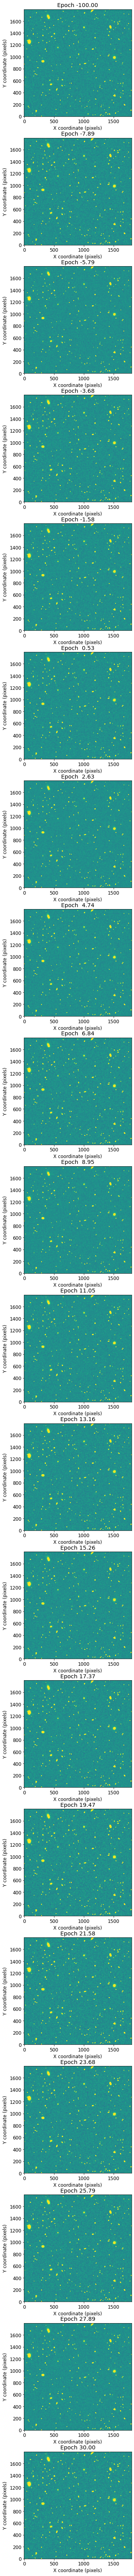

In [0]:
f, axarr = plt.subplots(nrows=len(field_dict['0']), ncols=1, figsize=(120, 120)) 

for i in range(len(sorted_field_dict['0'])):
  name = sorted_field_dict['0'][i]
  image = fits.open(name)[0].data
  scale=0.5
  epoch = str.split(name,'_')[-2]
  axarr[i].set_title('Epoch '+str(epoch))
  axarr[i].set_xlabel('X coordinate (pixels)')
  axarr[i].set_ylabel('Y coordinate (pixels)')
  axarr[i].imshow(image, origin='lower', vmin= -scale*np.std(image), vmax = scale*np.std(image))
  #axarr[i].scatter(np.around(sns_perField['0'][0]['x'].values), np.around(sns_perField['0'][0]['y'].values), 
           # s=100, marker='o', facecolors='none', edgecolors='r', lw=2, label='Supernovae')

## Magnitude Calculation

With the data organised in dictionaries, we perform the correction in the images (intercalibration, absolute calibration, seeing) and calculate the magnitude in the supernovas candidates 

In [0]:
#method to do the difference between images, from WP-SN-1, with a few adjustements as intercalibration and psf conversion

def normalize_psf(images_list,i1,i2,psf, intercalibration_list,adjust=0.05):
  image_1 = fits.open(images_list[i1])[0].data / intercalibration_list[i1]
  image_2 = fits.open(images_list[i2])[0].data / intercalibration_list[i2]
  sigma_1 = psf[i1]/(2*sqrt(2*log(2)))
  sigma_2 = psf[i2]/(2*sqrt(2*log(2)))
  if sigma_1 < sigma_2:
    sigma = sqrt(sigma_2**2-sigma_1**2)
    ker = Gaussian2DKernel(x_stddev=sigma+adjust)
    new_image_1 = convolve(image_1,ker,normalize_kernel=True)
    return(new_image_1,image_2,sigma_2)
  else:
    sigma = sqrt(sigma_1**2-sigma_2**2)
    ker = Gaussian2DKernel(x_stddev=sigma+adjust)
    new_image_2 = convolve(image_2,ker,normalize_kernel=True)
    return(image_1,new_image_2,sigma_1)

def diff_images(images_list, i1, i2, psf, intercalibration_list):
    im1,im2,s = normalize_psf(images_list, i1, i2, psf, intercalibration_list)
    return(im2-im1,s)

def printMatrix(a):
      nlin = 0
      ncol = 0
      for row in a:
          nlin +=1
          ncol=0
          for col in row:
              print("{:8.3f}".format(col), end=" ")
              ncol +=1
          print("")  
      print("linhas: ", nlin)
      print("colunas: ", ncol)  

With this, we can perform the magnitude calculation in a point of the image, with the method below. It was also shared with the group WP-SN-1

In [0]:
#Implementation of the method to calculate the magnitude
def calculate_magnitude(image, point_position, radius, abs_correction_factor):
  '''
    This function receives an image, an point and a radius in order to calculate the magnitude
    *Inputs*
      image == fits data, where we want to calculate the magnitude
      point_position == tuple (x,y)
      radius == float number
      abs_correction_factor == float number

    *Output*
      magnitude == float number
    '''

  #Initialization of the internal and external apperture, to calculate the flux and background
  aperture = photutils.CircularAperture(point_position, radius)
  annulus_aperture = CircularAnnulus(point_position, r_in=3*radius, r_out=4*radius)
  apers = [aperture, annulus_aperture]

  phot_table = photutils.aperture_photometry(image, apers, method='subpixel', subpixels=5)
      
  # for consistent table output
  for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  

  #The aperture_sum_0 column refers to the circular aperture
  #The aperture_sum_1 column refers to the circular annulus). 
  #We cannot simply subtract the aperture sums because the apertures have different areas.
  #To calculate the mean local background within the circular annulus aperture, we need to divide its sum by its area. 
  bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
  bkg_sum = bkg_mean * aperture.area #the total background within the circular aperture is then the mean local background times the circular aperture area
  final_flux = phot_table['aperture_sum_0'] - bkg_sum
      
  #Convert to float
  useful_flux = float(final_flux[0])
  magnitude = -2.5*log10(abs(useful_flux))+abs_correction_factor

  return magnitude

We then perform the calculation in all the Supernovas of all epochs and fields

In [0]:
#Make the difference between images, with respect to the reference (epoch -100)
correction_dict = {}
s_dict = {}

#Loop to fill the correction's dictionary, applying the making the difference between each epoch image and the one in epoch -100  
for field in range(nb_fields):
  correction_dict[str(field)] = []
  s_dict[str(field)] = []
  for ep in range(len(epoch_dict[str(field)])):
    correction, s = diff_images(sorted_field_dict[str(field)], 0, ep, psf_perField[str(field)], intercalibration[str(field)])
    correction_dict[str(field)].append(correction)
    s_dict[str(field)].append(s)

#Getting the magnitude of each identified supernova, in a dictionary with the field number as key and a matrix of magnitudes as value (lines are the supernovas and columns the epoch) 
magnitudes={}
for field in range(nb_fields):
  magnitudes[str(field)] = np.zeros((len(positions[str(field)]), len(correction_dict[str(field)])))
  for sn in range(len(positions[str(field)])):
    for ep in range(len(sorted_field_dict[str(field)])):
      image = correction_dict[str(field)][ep] 
      magn = calculate_magnitude(image, positions[str(field)][sn], radius[str(field)][ep], absolute_calibration[str(field)])   
      magnitudes[str(field)][sn][ep] = float(-magn)


## Lightcurves

So far, we have the magnitude dictionnary, with all the calculated magnitudes of each supernova, in each epoch, in each field. This is organized in magnitudes['field'][supernova_index][epoch]. With this information, we can plot the light curve for a supernova, using one of the methods below

In [0]:
def plot_lightcurve_lists(magnitude_list, epochs_list, initial_epoch_index=1):
  '''
    This function receives the magnitudes and epochs as lists, plotting the lightcurve
    As default, we don't show the first value, once that the magnitude calculation is based in the corrections 
  '''
  plt.plot(epochs_list[initial_epoch_index:], magnitude_list[initial_epoch_index:])

def plot_lightcurve(supernova_index, field_index, epochs_list, initial_epoch_index=1):
  '''
    This function receives the indexes of the supernova and the field (integers), plotting the lightcurve
    As default, we don't show the first value, once that the magnitude calculation is based in the corrections 
  '''
  y_mag = magnitudes[str(field_index)][supernova_index]
  plt.plot(epochs_list[initial_epoch_index:], y_mag[initial_epoch_index:])

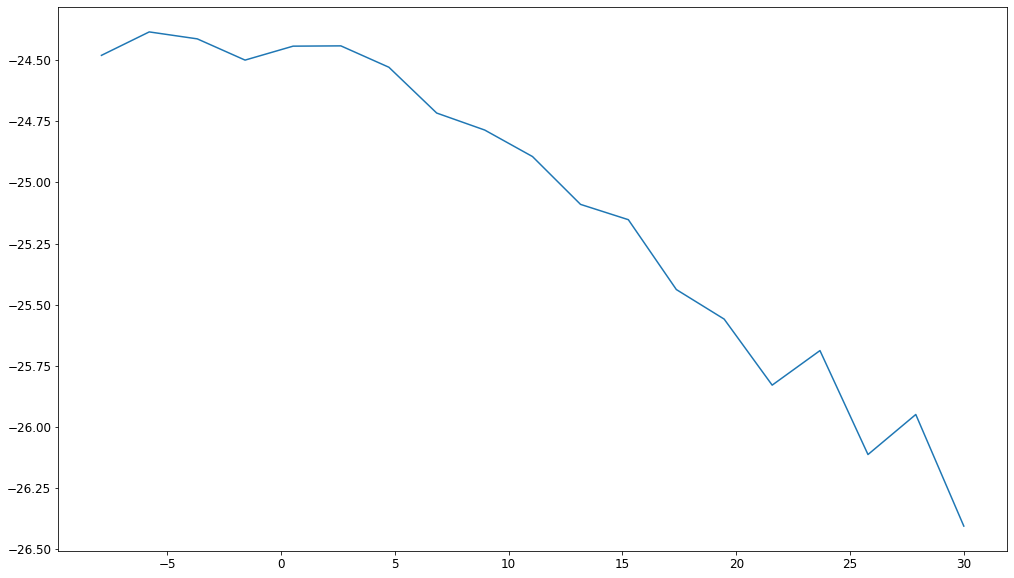

In [0]:
#Plot example, supernova 1, field 0
plot_lightcurve_lists(magnitudes['0'][1], epoch_dict['0'])


In [0]:
#Plot example, supernova 1, field 0
plot_lightcurve(1, 1, epoch_dict['0'])

-\
-\
-\
-\
-\
-\
BELOW IT ==> NOT CHECKED **YET**

In [0]:
#We calculated the sigma as the psf per field/2*sqrt(2*ln(2)) 

sigmas = {}

for i in range(nb_fields):
  sigmas[str(i)] = []
  for j in range (len(psf_perField[str(i)])):
    sigmas[str(i)].append(psf_perField[str(i)][j]/(2*sqrt(2*np.log(2))))

#Considering the pixel error value to be the same for the background and the signal, we propagate the error to obtain the final uncertainty of the pixels


sigma_pixel = {}

for i in range(nb_fields):
  sigma_pixel[str(i)] = []
  for j in range (len(sigmas[str(i)])):
    sigma_pixel[str(i)].append((sigmas[str(i)][j]**2)*sqrt(2))

#then we consider the uncertainty of the intercorrelation 
sigma_interco = {}

for i in range(nb_fields):
  sigma_interco[str(i)] = []
  for j in range (len(sigma_pixel[str(i)])):
    new_sigma = sqrt((error_intercalib[str(i)][j]/intercalibration[str(i)][j])**2 + (sigma_pixel[str(i)][j]/(sigma_pixel[str(i)][j]**2))**2)
    sigma_interco[str(i)].append(new_sigma)

#then we apply the formula of the flux error of the library


flux_error = {}

for i in range(nb_fields):
   flux_error[str(i)] = np.zeros((len(positions[str(i)]), len(sorted_field_dict['0'])))
   for sn in range(len(positions[str(i)])):
     for ep in range(len(sorted_field_dict['0'])):
       aperture = photutils.CircularAperture(positions[str(i)][sn], r=radius[str(i)][ep])
       name = sorted_field_dict[str(i)][ep]
       image = fits.open(name)[0].data
       error = (sigma_interco[str(i)][ep])*image
       phot_table = photutils.aperture_photometry(image, aperture, error=error)
       flux_uncertainty = phot_table['aperture_sum_err']
       flux_error[str(i)][sn][ep] = float(flux_uncertainty)
      
print(flux_error)

######
sigma_tot = {}



for i in range(nb_fields):
  sigma_tot[str(i)] = []
  for j in range (len(sigma_interco[str(i)])):
    final = sqrt((sigma_interco[str(i)][j]**2) + (error_abs_calib[str(i)]**2))
    sigma_tot[str(i)].append(final)

print(sigma_tot)

{'0': [0.661070530190339, 0.3215579543138825, 0.8010034959680116, 0.3244307998771731, 0.45543809638899646, 0.38570001075911214, 0.7452816341458799, 0.7002784881225286, 0.36429111279990367, 0.8922793586122452, 0.6299661107265838, 0.41384137823907763, 0.6525012079545399, 0.5151785273436557, 0.26811807819185096, 0.26728365230058226, 0.40120296077696993, 0.41864150873493033, 0.9525501868082745, 0.25355042704315145], '1': [0.6610874653903228, 0.3215614509440577, 0.8010182087163936, 0.3244486707308026, 0.4554389360156567, 0.3857067146245893, 0.7452986977087145, 0.7002958425317279, 0.36430331321248594, 0.8922951576234699, 0.6299985941931048, 0.4138655754519034, 0.6525342725301793, 0.5151932038069451, 0.26816047725100745, 0.2673150233183937, 0.4012257509679973, 0.41866005322311334, 0.9525593517482754, 0.25360778459100464], '2': [0.6610159775986542, 0.3218611563003744, 0.8009448370889984, 0.32467475811486907, 0.4555020554058644, 0.3857930022183825, 0.7452198325475777, 0.7002162612106769, 0.3644

We can also plot the lightcurve of a give supernova as a function of epoch. Note that we have to perform a complicated replacement of characters in this very case as a bug in the file production induced the presence of brackets characters in the magnitudes of supernovae (not for stars or for galaxies).

In [0]:
sn_num =13
lightcurve_sn = np.zeros(len(epochs))
for i in range(len(epochs)):
  lightcurve_sn[i] = float(all_sns[i]['magnitudes'].values[sn_num].replace('[','').replace(']',''))
  
## We plot -magnitude instead of + as they are in reverse order...
## We also display the redshift, strectch factor and date of maximum of the SNIa
plot(epochs, -lightcurve_sn, label='Light Curve')
xlabel('Days in local reference frame')
ylabel('-Magnitude')
title('Supernova #{0:} - redshift={1:5.2f} - Stretch={2:5.2f}'.format(sn_num, all_sns[0]['redshifts'].values[sn_num], 
                                                                      all_sns[0]['stretches'].values[sn_num]))
plot([datemax[sn_num],datemax[sn_num]], [-40,-22], 'g--', label='Date of Maximum')
legend()

In [0]:
imwi = pandas.read_csv(directory+globalname+str(i)+'_sns.csv')
imwi